In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt
import shap

e:\miniconda\envs\_pytorch3.10_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define a list of data augmentation transformations to apply
augmentations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
]

# Define the transform for the data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomApply(augmentations, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root='E:/Downloads/grad/111_1/data science instroduction/final_project/Pineapple_image', transform=transform)

# Get the labels for each sample in the dataset
labels = [label for _, label in dataset] # 0~8

# Create the stratified shuffle split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Split the dataset into train and test sets
for train_index, test_index in sss.split(dataset, labels):
    train_set = torch.utils.data.Subset(dataset, train_index)
    test_set = torch.utils.data.Subset(dataset, test_index)

# Create the dataloaders
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Create the dataloaders
# trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, transform=transform)
# testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, transform=transform)

classes = ('stage_501', 'stage_505', 'stage_509', 'stage_601',
           'stage_605', 'stage_609', 'stage_701', 'stage_705', 'stage_709')

model = EfficientNet.from_pretrained('efficientnet-b0')


Loaded pretrained weights for efficientnet-b0


In [3]:
len(dataset)

1800

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


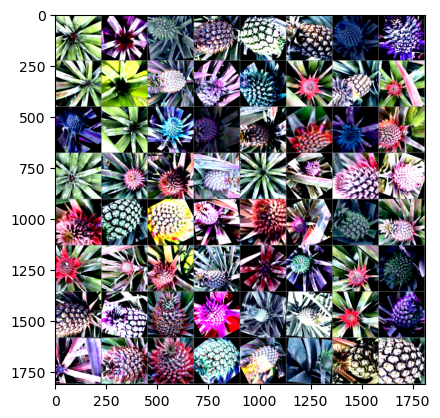

stage_501 stage_501 stage_605 stage_705 stage_709 stage_709 stage_601 stage_605 stage_501


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(9)))

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)


In [6]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
            losses.append(loss.item())

    acc = correct / len(dataloader.dataset)
    cm = confusion_matrix(y_true, y_pred)
    return total_loss / len(dataloader), acc, cm, losses

In [7]:
patience = 3
num_epochs = 20
best_val_loss = float('inf')
epochs_without_improvement = 0
acc_test_curve = []
losses_test_curve = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    val_loss, val_acc, cm, losses = evaluate(model, testloader, criterion)
    print('Epoch {}: train loss = {}, train acc = {}, val loss = {}, val acc = {}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc))
    losses_test_curve.append(losses)
    acc_test_curve.append(val_acc)
    # Check if the validation loss has improved
    if val_loss < best_val_loss:
        # Update the best validation loss
        best_val_loss = val_loss
        
        # Reset the counter for the number of epochs without improvement
        epochs_without_improvement = 0
    else:
        # Increment the counter for the number of epochs without improvement
        epochs_without_improvement += 1
        
        # Check if the number of epochs without improvement has reached the patience threshold
        if epochs_without_improvement >= patience:
            # Stop the training loop
            print('Early stopping at epoch {}'.format(epoch+1))
            break

Epoch 1: train loss = 1.7460360028173612, train acc = 0.6472222222222223, val loss = 2.6865708033243814, val acc = 0.5444444444444444
Epoch 2: train loss = 0.3704550502740819, train acc = 0.8798611111111111, val loss = 0.9507940113544464, val acc = 0.7305555555555555
Epoch 3: train loss = 0.23355878954348358, train acc = 0.9097222222222222, val loss = 1.153375913699468, val acc = 0.7722222222222223
Epoch 4: train loss = 0.22489887022453806, train acc = 0.9180555555555555, val loss = 1.0030802885691326, val acc = 0.7972222222222223
Epoch 5: train loss = 0.16813590247993884, train acc = 0.9375, val loss = 0.6229960471391678, val acc = 0.8555555555555555
Epoch 6: train loss = 0.18452648607933003, train acc = 0.9347222222222222, val loss = 0.47095784544944763, val acc = 0.8833333333333333
Epoch 7: train loss = 0.12619040436718776, train acc = 0.95625, val loss = 0.27495456486940384, val acc = 0.9194444444444444
Epoch 8: train loss = 0.17001395583476708, train acc = 0.9506944444444444, val 

In [8]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [9]:
losses_curve = flatten(losses_test_curve)

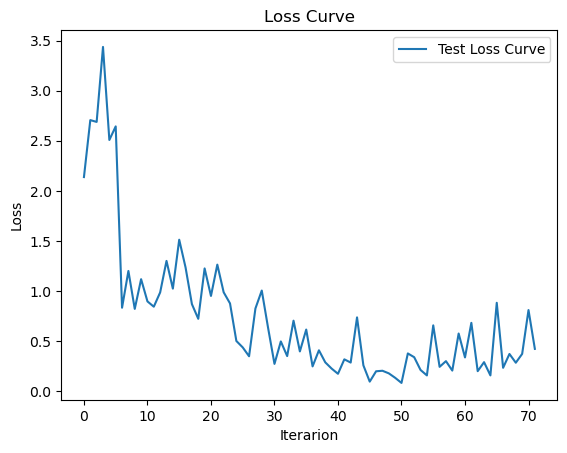

In [10]:
plt.title("Loss Curve")
plt.plot(losses_curve, label="Test Loss Curve")
plt.xlabel("Iterarion")
plt.ylabel("Loss")
plt.legend()
plt.show()

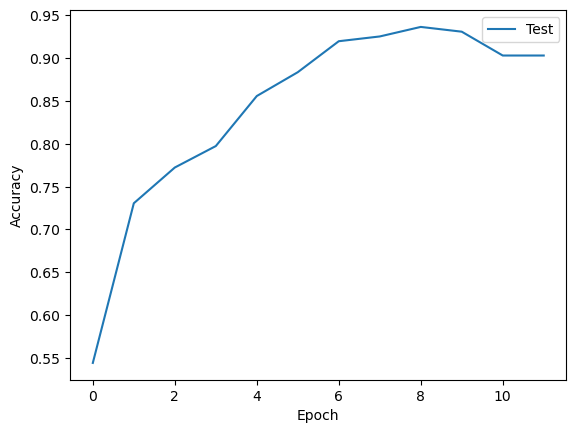

In [11]:
plt.plot(acc_test_curve, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
cm

array([[40,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 34,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  5, 35,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 37,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 32,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 36,  3,  0],
       [ 0,  0,  0,  1,  0,  0,  5, 32,  2],
       [ 0,  0,  0,  1,  0,  0,  0,  0, 39]], dtype=int64)

In [13]:
PATH = 'D:/PycharmProjects/pipeapple_classification_task/efficient_netb0_AdamW/efficient_netb0_AdamW.pth'
torch.save(model.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


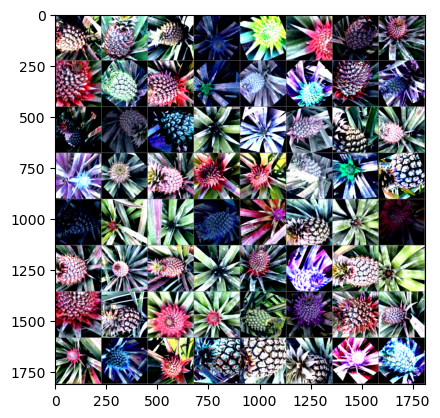

GroundTruth:  stage_705 stage_701 stage_701 stage_509 stage_601 stage_601 stage_705 stage_605 stage_601


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(9)))

In [15]:
# model = EfficientNet(blocks_args=blocks_args)
# model.load_state_dict(torch.load(PATH))

In [16]:
outputs = model(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(0)))

Predicted:  


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: stage_501 is 100.0 %
Accuracy for class: stage_505 is 90.0 %
Accuracy for class: stage_509 is 87.5 %
Accuracy for class: stage_601 is 100.0 %
Accuracy for class: stage_605 is 90.0 %
Accuracy for class: stage_609 is 75.0 %
Accuracy for class: stage_701 is 87.5 %
Accuracy for class: stage_705 is 77.5 %
Accuracy for class: stage_709 is 100.0 %
